Itt a trükk az, hogy a downsampling súlyait használjuk az upsamplingnél.

A célja pedig hogy csak inputokból tudjuk tanítani a hálónkat.

![alt text](https://miro.medium.com/max/3524/1*oUbsOnYKX5DEpMOK3pH_lg.png)

Később ha kell akkor tanítás után levágható a decoder része

Ajánlott a U-Net kódot tanulmányozni előtte

Extracting tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0, loss: 0.0971949
Iteration: 100, loss: 0.064114064
Iteration: 200, loss: 0.06592451
Iteration: 300, loss: 0.070535876
Iteration: 400, loss: 0.06241579
Iteration: 500, loss: 0.06812831
Iteration: 600, loss: 0.05841769
Iteration: 700, loss: 0.05525028
Iteration: 800, loss: 0.05216489
Iteration: 900, loss: 0.053099845


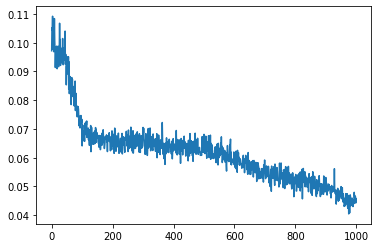

In [0]:
#import

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from tensorflow.examples.tutorials.mnist import input_data as data 
mnist = data.read_data_sets('tmp/MNIST_data/', one_hot=False)


#hyperparameters

input_shape = [28, 28, 1]
batch_size = 64
num_kernels = [input_shape[-1], 32, 64, 128, 256, 10]
num_iterations = 1000


#graph building

tf.reset_default_graph()

#elég egy placeholder, mivel ezt használom label helyett is
input_data = tf.placeholder(tf.float32, [batch_size] + input_shape)

current_input = input_data

#ide csak bementem a layereken az adott képek méreteit, hogy ne kelljen undorítóan szorozgatni upsamplingnél
img_sizes = []

#ebbe pedig a súlyok fognak kerülni
weights = []

for i in range(0, len(num_kernels)-1):
  with tf.variable_scope('downLayer' + str(i)):
    w = tf.get_variable('kernel', [3, 3, num_kernels[i], num_kernels[i+1]])
    b = tf.get_variable('b', [num_kernels[i+1]])

    #belerakjuk az adott kernelt
    weights.append(w)

    current_input = tf.nn.conv2d(current_input, w, strides=[1,1,1,1], padding='SAME')
    current_input = tf.add(current_input, b)
    current_input = tf.nn.relu(current_input)

    #belerakom a kép alakját
    img_sizes.append([current_input.shape[1], current_input.shape[2]])

    current_input = tf.nn.max_pool(current_input, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#végigiterálok az utolsó előtti elemtől az elsőig
for i in range(len(num_kernels)-2, -1, -1):
  with tf.variable_scope('upLayer' + str(i)):

    #odaadom neki a lementett súlyt
    w = weights[i]

    b = tf.get_variable('bias', [num_kernels[i]])

    current_input = tf.nn.conv2d_transpose(current_input, w, [batch_size, img_sizes[i][0], img_sizes[i][1], num_kernels[i]], strides=[1,2,2,1], padding='SAME')
    current_input = tf.add(current_input, b)
    current_input = tf.nn.relu(current_input)

    #itt nem alkalmazunk külön konvolúciót a layeren belül


with tf.variable_scope('loss'):

  #négyzetes hibát nézünk -> tf.square tf.abs helyett
  #és itt a labelként használjuk az input_datát
  loss = tf.reduce_mean(tf.square(tf.subtract(current_input, input_data)))

with tf.variable_scope('optimizer'):
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)


#session

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  loss_plot = np.zeros(num_iterations)

  for i in range(0, num_iterations):
    used_in_batch = random.sample(range(len(mnist.train.images)), batch_size)

    #reshapelnünk kell mint a CNNben
    batch_x = np.reshape(mnist.train.images[used_in_batch], [batch_size] + input_shape)

    _, l = sess.run([optimizer, loss], feed_dict={input_data: batch_x})

    loss_plot[i]=l

    if i%100 == 0:
      print('Iteration: ' + str(i) + ', loss: ' + str(l))

plt.plot(loss_plot)
